**Deep Neural Architecture for Face mask Detection on Simulated Masked Face Dataset against Covid-19 Pandemic**

In [ ]:
!pip install tensorflow==2.8.0

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ac7f8023-f244-eae1-4394-349af059f5cd)


# Importing Dependencies

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
from keras.layers import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os

In [4]:
print(tf.__version__)

2.8.0


# Loading Data

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

In [ ]:
! unzip face-mask-12k-images-dataset.zip

**Length of Data**

In [8]:
total_train_with_mask = len(os.listdir('/content/Face Mask Dataset/Train/WithMask'))
total_train_without_mask = len(os.listdir('/content/Face Mask Dataset/Train/WithoutMask'))
total_test_with_mask = len(os.listdir('/content/Face Mask Dataset/Test/WithMask'))
total_test_without_mask = len(os.listdir('/content/Face Mask Dataset/Test/WithoutMask'))
total_val_with_mask = len(os.listdir('/content/Face Mask Dataset/Validation/WithMask'))
total_val_without_mask = len(os.listdir('/content/Face Mask Dataset/Validation/WithoutMask'))

print("Train sets images with mask: {}".format(total_train_with_mask))
print('--------------------------------------------')
print("Train sets images without mask: {}".format(total_train_without_mask))
print('--------------------------------------------')
print("Test sets images with mask: {}".format(total_test_with_mask))
print('--------------------------------------------')
print("Test sets images without mask: {}".format(total_test_without_mask))
print('--------------------------------------------')
print("Val sets images with mask: {}".format(total_val_with_mask))
print('--------------------------------------------')
print("Val sets images without mask: {}".format(total_val_without_mask))

Train sets images with mask: 5000
--------------------------------------------
Train sets images without mask: 5000
--------------------------------------------
Test sets images with mask: 483
--------------------------------------------
Test sets images without mask: 509
--------------------------------------------
Val sets images with mask: 400
--------------------------------------------
Val sets images without mask: 400


**How image Looks**

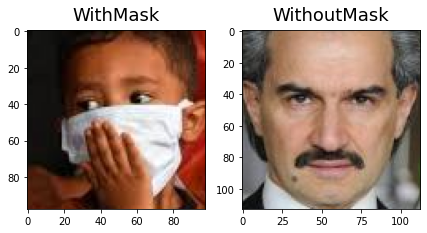

In [7]:
dataset='/content/Face Mask Dataset'
train_folder = os.path.join(dataset,"Train")


images = []


for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

# Image Proccessing

In [41]:
train_datagen = ImageDataGenerator( horizontal_flip=True,
                                   shear_range=0.2,
                                  rescale= 1./255,
                                  zoom_range=0.2,)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_path='/content/Face Mask Dataset/Train'
test_path = '/content/Face Mask Dataset/Test'
val_path = '/content/Face Mask Dataset/Validation'

train_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(200,200),
        batch_size=32,
        shuffle = False,
        seed = 42,
         class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(200,200),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

val_set = val_datagen.flow_from_directory(
        val_path,
        target_size=(200,200),
        seed = 42,
        shuffle = False,
        batch_size=32,
        class_mode = "categorical",
        classes = ['WithoutMask','WithMask'])

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [23]:
train_set.class_indices

{'WithoutMask': 0, 'WithMask': 1}

# After Proccessing

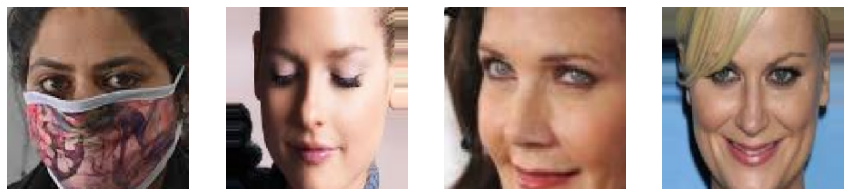

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
  image = next(train_set)[0]
  image = np.squeeze(image)
  ax[i].imshow(image)
  ax[i].axis('off')

# Model Building

# VGG16

In [11]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

In [12]:
vgg = VGG16(input_shape= (200,200,3), weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
vgg_history = model.fit(train_set,
                           epochs=5,
                           validation_data=val_set,
                           steps_per_epoch=(len(train_set.labels)/48) ,
                            validation_steps=(len(val_set.labels)/48))

Epoch 1/5
208/208 [==============================] - 104s 493ms/step - loss: 0.6434 - accuracy: 0.8334 - val_loss: 0.0315 - val_accuracy: 0.9912
Epoch 2/5
208/208 [==============================] - 105s 505ms/step - loss: 0.0595 - accuracy: 0.9803 - val_loss: 0.0166 - val_accuracy: 0.9962
Epoch 3/5
208/208 [==============================] - 102s 489ms/step - loss: 0.0699 - accuracy: 0.9758 - val_loss: 0.0150 - val_accuracy: 0.9962
Epoch 4/5
208/208 [==============================] - 129s 621ms/step - loss: 0.0542 - accuracy: 0.9792 - val_loss: 0.0356 - val_accuracy: 0.9850
Epoch 5/5
208/208 [==============================] - 118s 565ms/step - loss: 0.0514 - accuracy: 0.9826 - val_loss: 0.0229 - val_accuracy: 0.9950


**Plot**

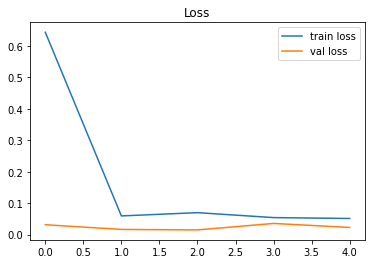

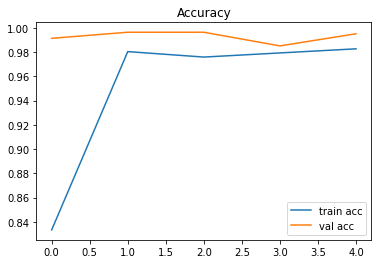

In [26]:
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

# Evaluation

In [27]:
vgg_evaluate = model.evaluate(test_set)

21/21 [==============================] - 4s 199ms/step - loss: 0.0229 - accuracy: 0.9940


In [28]:
test_pred = model.predict(test_set)
val_pred = model.predict(val_set)
test_pred = np.argmax(test_pred,axis = 1)
val_pred = np.argmax(val_pred,axis = 1)

test_labels = test_set.labels
val_labels = val_set.labels

**Test Data Evaluation**

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

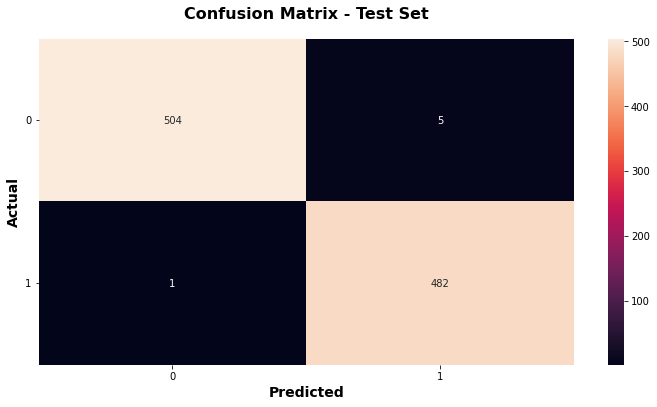

In [35]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       509
           1       0.99      1.00      0.99       483

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



**Validation Data Evaluation**

Text(0.5, 1.0, 'Confusion Matrix - Validation Set')

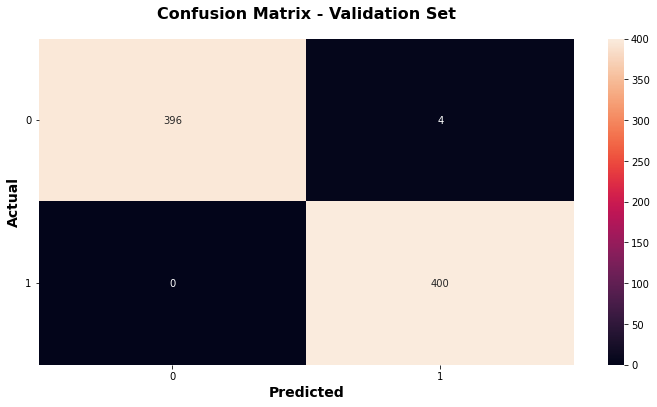

In [37]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    val_labels,
    val_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(val_labels,val_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.99      1.00      1.00       400

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



# CNN

In [48]:
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

**Proposed Architecture**

In [ ]:
image_size = (200,200,3)

model = keras.Sequential()
model.add(Conv2D( 16,(3,3), activation = "relu", input_shape = image_size))
model.add(Conv2D( 16, (3,3), activation = "relu"))
model.add(MaxPool2D(2,2))
model.add(Conv2D( 32, (3,3), activation = "relu"))
model.add(Conv2D( 32, (3,3), activation = "relu"))
model.add(MaxPool2D(2,2))
model.add(Conv2D( 64, (3,3), activation = "relu"))
model.add(Conv2D( 64, (3,3), activation = "relu"))
model.add(MaxPool2D(2,2))
model.add(Conv2D( 96, (3,3), activation = "relu"))
model.add(Conv2D( 96, (3,3), activation = "relu"))
model.add(MaxPool2D(2,2))
model.add(Conv2D( 128, (3,3), activation = "relu"))
model.add(Conv2D( 128, (3,3), activation = "relu"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))


model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

**Custom Architecture**

In [ ]:
model = Sequential()

model.add(layers.Conv2D(64,(3,3),activation='relu',strides=2 ,input_shape=(200,200,3)))
model.add(layers.Conv2D(128,(3,3),activation='relu',strides=2))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32,(3,3),activation='relu',strides=1))
model.add(layers.Conv2D(64,(3,3),activation='relu',strides=1))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,'softmax'))

model.summary()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

In [50]:
cnn_history = model.fit(train_set,epochs=10,validation_data=val_set)

Epoch 1/10
313/313 [==============================] - 97s 307ms/step - loss: 0.4788 - accuracy: 0.7884 - val_loss: 0.2426 - val_accuracy: 0.9025
Epoch 2/10
313/313 [==============================] - 93s 298ms/step - loss: 0.2259 - accuracy: 0.9190 - val_loss: 0.1523 - val_accuracy: 0.9475
Epoch 3/10
313/313 [==============================] - 92s 293ms/step - loss: 0.1990 - accuracy: 0.9247 - val_loss: 0.1374 - val_accuracy: 0.9550
Epoch 4/10
313/313 [==============================] - 94s 302ms/step - loss: 0.1514 - accuracy: 0.9443 - val_loss: 0.1048 - val_accuracy: 0.9663
Epoch 5/10
313/313 [==============================] - 91s 292ms/step - loss: 0.1086 - accuracy: 0.9587 - val_loss: 0.0723 - val_accuracy: 0.9800
Epoch 6/10
313/313 [==============================] - 91s 291ms/step - loss: 0.1003 - accuracy: 0.9656 - val_loss: 0.0482 - val_accuracy: 0.9825
Epoch 7/10
313/313 [==============================] - 93s 298ms/step - loss: 0.0820 - accuracy: 0.9691 - val_loss: 0.0386 - val_ac

**Plot**

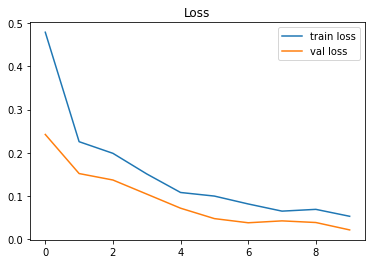

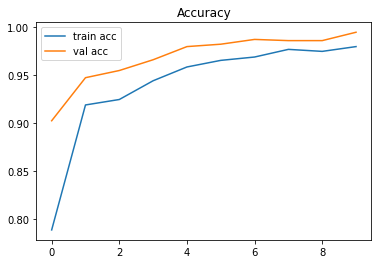

In [51]:
plt.plot(cnn_history.history['loss'], label='train loss')
plt.plot(cnn_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

plt.plot(cnn_history.history['accuracy'], label='train acc')
plt.plot(cnn_history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

# Evaluation

In [52]:
cnn_evaluate = model.evaluate(test_set)

31/31 [==============================] - 2s 60ms/step - loss: 0.0721 - accuracy: 0.9768


In [53]:
test_pred = model.predict(test_set)
val_pred = model.predict(val_set)
test_pred = np.argmax(test_pred,axis = 1)
val_pred = np.argmax(val_pred,axis = 1)

test_labels = test_set.labels
val_labels = val_set.labels

**Test Data Evaluation**

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

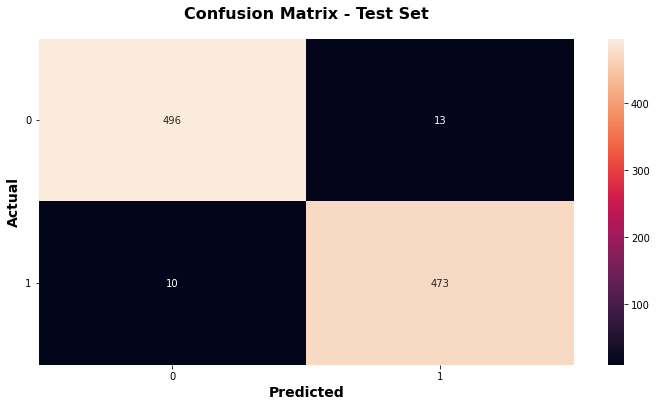

In [54]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       509
           1       0.97      0.98      0.98       483

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



**Validation Data Evaluation**

Text(0.5, 1.0, 'Confusion Matrix - Validation Set')

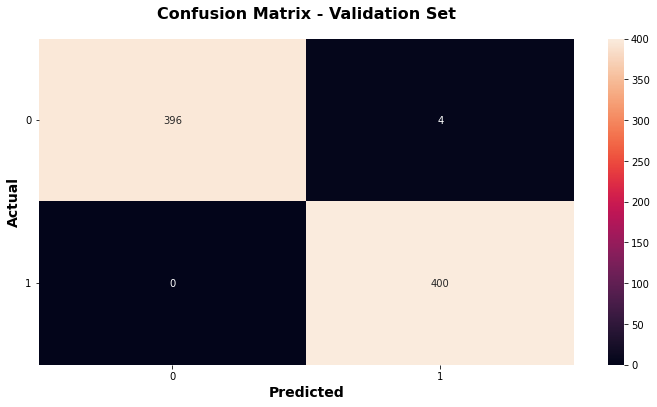

In [56]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    val_labels,
    val_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Validation Set',fontsize = 16,weight = 'bold',pad=20)

In [63]:
from sklearn.metrics import *
print(classification_report(val_labels,val_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.99      1.00      1.00       400

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



# Comparing Both models

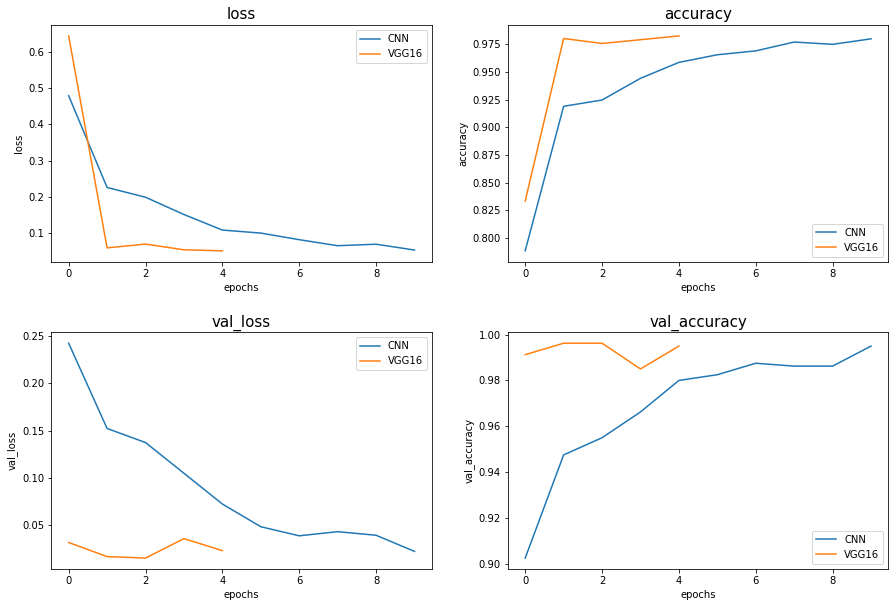

In [58]:
model_hist = [cnn_history,vgg_history]
names = ['CNN', 'VGG16']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_hist[0].history:
    index = list(model_hist[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_hist:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()

In [67]:
data={'Models':['CNN','VGG16'],
      'Test_Accuracy':['97.68','99.4'],
      'Val_Accuracy': ['98.67','99.5'],
      'Test_precision':['98.0','100'],
      'val_precision':['100','100'],
      'Test_recall':['98.0','99.0'],
      'Val_recall':['99.0','99.0'],
      'Test_f1':['98.0','99.0'],
      'Val_f1':['99.0','99.0'],

      }

df =pd.DataFrame(data)

df


,Models,Test_Accuracy,Val_Accuracy,Test_precision,val_precision,Test_recall,Val_recall,Test_f1,Val_f1
0,CNN,97.68,98.67,98.0,100,98.0,99.0,98.0,99.0
1,VGG16,99.4,99.5,100,100,99.0,99.0,99.0,99.0
